<a href="https://colab.research.google.com/github/WNderitu/Malaria-Parasite-Detector-version-2/blob/main/5_model_eval_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plasmodium Vivax (malaria) parasite detector and counter

Notebook 5:Model evaluation on test images Notebook

YOLOv8n model variant/size

In [1]:
from google.colab import drive

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Mounted at /content/drive
Google Drive mounted successfully!


## 5.0 Install required libraries

In [3]:
!pip install matplotlib --quiet
!pip install Pillow --quiet #installing PILLOW LIBRARY
!pip install imagehash --quiet
!pip install pyyaml --quiet
!pip install ultralytics --quiet

## 5.1 Detailed Performance Analysis on Test Set using Best.pt from fine tune v1

### 5.1.1 *Evaluation*

In [ ]:
import pandas as pd
from ultralytics import YOLO

# --- Configuration ---
# 1. Path to your trained weights file
weights_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'

# 2. Path to your dataset configuration file
# This file must contain the 'names' of your malaria parasite classes
data_yaml_path = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

# 3. Output directory for results (will be inside runs/detect/val)
project_name = 'malaria_yolov8n_test_evaluation'
run_name = 'v1_test_set_results'

# --- Load Model ---
try:
    model = YOLO(weights_path)
    print(f"Successfully loaded model from: {weights_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- Run Validation (Evaluation) ---
print("\nStarting evaluation on the test set...")
# The split='test' argument tells YOLOv8 to look for the 'test' directory
# inside the path specified in your data.yaml, if it's structured correctly.
# Setting plots=True saves the Confusion Matrix and PR curves to the output folder.
metrics = model.val(
    data=data_yaml_path,
    split='test',  # Use 'test' split if configured, otherwise rely on the 'val' path in the YAML
    imgsz=1280,    # same image size used during fine tuning
    conf=0.001,    # Default used for mAP calculation
    iou=0.7,       # Default NMS IoU used for mAP calculation
    project=project_name,
    name=run_name,
    plots=True,     # Saves plots like Confusion Matrix and PR curves
    verbose=True
)

print("\n--- Evaluation Complete ---")

# --- Step 2: Extract and Display Per-Class Metrics ---

# The `box.ap` attribute contains the per-class Average Precision (AP) at IoU 0.5:0.95
# Corrected: metrics.box.mp is the overall mAP, metrics.box.ap is per-class AP@.5:.95
per_class_ap_list = metrics.box.ap
class_names = metrics.names

# The per-class Precision and Recall are extracted from the results object
# (at optimum confidence/IoU). These should be arrays indexed by class ID.
per_class_precision = metrics.box.p
per_class_recall = metrics.box.r

# --- Step 3: Format Output as a Pandas DataFrame ---

# Initialize a dictionary to store the results
results_data = {
    'Class ID': [],
    'Class Name': [],
    'P (Precision)': [],
    'R (Recall)': [],
    'AP@.5:.95 (Mean Avg. Precision)': []
}

# Populate the dictionary
for i, name in class_names.items():
    results_data['Class ID'].append(i)
    results_data['Class Name'].append(name)

    # Initialize values as 'N/A'
    p_val = 'N/A'
    r_val = 'N/A'
    ap_val = 'N/A'

    # Safely try to get Precision value
    # Check if the index 'i' is within the bounds of the array and if the value is not NaN
    if i < len(per_class_precision) and not pd.isna(per_class_precision[i]):
        p_val = per_class_precision[i].item()

    # Safely try to get Recall value
    if i < len(per_class_recall) and not pd.isna(per_class_recall[i]):
        r_val = per_class_recall[i].item()

    # Safely try to get AP@.5:.95 value
    # Ensure per_class_ap_list is correctly assigned (metrics.box.ap) before this loop
    if i < len(per_class_ap_list) and not pd.isna(per_class_ap_list[i]):
        ap_val = per_class_ap_list[i].item()

    results_data['P (Precision)'].append(p_val)
    results_data['R (Recall)'].append(r_val)
    results_data['AP@.5:.95 (Mean Avg. Precision)'].append(ap_val)

# Create the DataFrame
df_metrics = pd.DataFrame(results_data)

# Calculate F1-Score for better balance assessment
# Handle 'N/A' or 'ERROR' by converting to numeric, filling missing values with 0 for calculation
P_numeric = pd.to_numeric(df_metrics['P (Precision)'], errors='coerce').fillna(0)
R_numeric = pd.to_numeric(df_metrics['R (Recall)'], errors='coerce').fillna(0)
df_metrics['F1-Score'] = (2 * P_numeric * R_numeric) / (P_numeric + R_numeric).replace(0, 1e-6)

# Final Display
print("\n#####################################################")
print("### DETAILED PER-CLASS MALARIA DETECTION METRICS ON TEST IMAGES ###")
print("#####################################################")
print(df_metrics.to_string(index=False))

# --- Step 4: Access Overall Metrics (Optional) ---
print("\n--- Overall Metrics (mAP) ---")
print(f"Overall mAP@0.5: {metrics.box.map50}")
print(f"Overall mAP@0.5:0.95: {metrics.box.map}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Successfully loaded model from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt

Starting evaluation on the test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 6.6±9.5 ms, read: 14.5±30.8 MB/s, size: 250.7 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_finetune/labels/test.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 148.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)

### 5.1.2 Evaluation 2 with different conf=0.25 & iou=0.5

In [ ]:
import pandas as pd
from ultralytics import YOLO

# --- Configuration ---
# 1. Path to your trained weights file
weights_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'

# 2. Path to your dataset configuration file
# This file must contain the 'names' of your malaria parasite classes
data_yaml_path = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

# 3. Output directory for results (will be inside runs/detect/val)
project_name = 'malaria_yolov8n_test_evaluation'
run_name = 'v1_test_set_results'

# --- Load Model ---
try:
    model = YOLO(weights_path)
    print(f"Successfully loaded model from: {weights_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- Run Validation (Evaluation) ---
print("\nStarting evaluation on the test set...")
# The split='test' argument tells YOLOv8 to look for the 'test' directory
# inside the path specified in your data.yaml, if it's structured correctly.
# Setting plots=True saves the Confusion Matrix and PR curves to the output folder.
metrics = model.val(
    data=data_yaml_path,
    split='test',  # Use 'test' split if configured, otherwise rely on the 'val' path in the YAML
    imgsz=1280,    # same image size used during fine tuning
    conf=0.25,    # Default used for mAP calculation
    iou=0.5,       # Default NMS IoU used for mAP calculation
    project=project_name,
    name=run_name,
    plots=True,     # Saves plots like Confusion Matrix and PR curves
    verbose=True
)

print("\n--- Evaluation Complete ---")

# --- Step 2: Extract and Display Per-Class Metrics ---

# The `box.ap` attribute contains the per-class Average Precision (AP) at IoU 0.5:0.95
# Corrected: metrics.box.mp is the overall mAP, metrics.box.ap is per-class AP@.5:.95
per_class_ap_list = metrics.box.ap
class_names = metrics.names

# The per-class Precision and Recall are extracted from the results object
# (at optimum confidence/IoU). These should be arrays indexed by class ID.
per_class_precision = metrics.box.p
per_class_recall = metrics.box.r

# --- Step 3: Format Output as a Pandas DataFrame ---

# Initialize a dictionary to store the results
results_data = {
    'Class ID': [],
    'Class Name': [],
    'P (Precision)': [],
    'R (Recall)': [],
    'AP@.5:.95 (Mean Avg. Precision)': []
}

# Populate the dictionary
for i, name in class_names.items():
    results_data['Class ID'].append(i)
    results_data['Class Name'].append(name)

    # Initialize values as 'N/A'
    p_val = 'N/A'
    r_val = 'N/A'
    ap_val = 'N/A'

    # Safely try to get Precision value
    # Check if the index 'i' is within the bounds of the array and if the value is not NaN
    if i < len(per_class_precision) and not pd.isna(per_class_precision[i]):
        p_val = per_class_precision[i].item()

    # Safely try to get Recall value
    if i < len(per_class_recall) and not pd.isna(per_class_recall[i]):
        r_val = per_class_recall[i].item()

    # Safely try to get AP@.5:.95 value
    # Ensure per_class_ap_list is correctly assigned (metrics.box.ap) before this loop
    if i < len(per_class_ap_list) and not pd.isna(per_class_ap_list[i]):
        ap_val = per_class_ap_list[i].item()

    results_data['P (Precision)'].append(p_val)
    results_data['R (Recall)'].append(r_val)
    results_data['AP@.5:.95 (Mean Avg. Precision)'].append(ap_val)

# Create the DataFrame
df_metrics = pd.DataFrame(results_data)

# Calculate F1-Score for better balance assessment
# Handle 'N/A' or 'ERROR' by converting to numeric, filling missing values with 0 for calculation
P_numeric = pd.to_numeric(df_metrics['P (Precision)'], errors='coerce').fillna(0)
R_numeric = pd.to_numeric(df_metrics['R (Recall)'], errors='coerce').fillna(0)
df_metrics['F1-Score'] = (2 * P_numeric * R_numeric) / (P_numeric + R_numeric).replace(0, 1e-6)

# Final Display
print("\n#####################################################")
print("### DETAILED PER-CLASS MALARIA DETECTION METRICS ON TEST IMAGES ###")
print("#####################################################")
print(df_metrics.to_string(index=False))

# --- Step 4: Access Overall Metrics (Optional) ---
print("\n--- Overall Metrics (mAP) ---")
print(f"Overall mAP@0.5: {metrics.box.map50}")
print(f"Overall mAP@0.5:0.95: {metrics.box.map}")

Successfully loaded model from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt

Starting evaluation on the test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 2.3±4.2 ms, read: 66.0±40.5 MB/s, size: 234.1 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_finetune/labels/test.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 74.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 15.8s/it 2:06
                   all        120       5922      0.391      0.286      0.332      0.263
        red blood cell        120       5614       0.94      0.903      0.926      0.752
              schizont          9         11          0          0          0          0
       

### 5.1.3 Issues noted

Model is essentially failing to detect or correctly classify the most important objects—the parasites (schizont, ring, trophozoite, gametocyte, leukocyte). The zero Recall for the 'ring' class is a critical failure point. Given that rings are often the most numerous stage, this suggests a fundamental problem. There are detection issue that need to be solved.

There seems to be a data quality, labeling, or configuration issue.

Check the following:
- Data and Label Sanity Check (Highest Priority)
The zero P/R for 'ring' and N/A for 'trophozoite' strongly suggests a problem with how these classes are handled.
- Review data.yaml:
Verify that the class names in your data.yaml (names: section) exactly match the class IDs (0, 1, 2, 3, 4, 5) that were used in your training and test set labels. Example: Is ring class ID 3? Is trophozoite class ID 5?
- Review Test Set Labels:
Manually inspect several images and their corresponding .txt label files in your test set to ensure the 'ring' and 'trophozoite' bounding boxes are present, correctly formatted (class_id x_center y_center width height), and the class ID is correct. Use a visualization tool (like Roboflow or the Ultralytics built-in predict with save_txt=True) to visualize the ground truth labels overlayed on the images.

### 5.1.4 Review of Data YAML

In [ ]:
import yaml
from pathlib import Path

# --- Configuration ---
# Set the path to your data.yaml file
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

def inspect_data_yaml(yaml_path):
    """
    Reads the data.yaml file and prints key sections for verification.
    """
    yaml_file = Path(yaml_path)

    if not yaml_file.exists():
        print(f"🚨 ERROR: YAML file not found at {yaml_path}")
        return

    try:
        with open(yaml_file, 'r') as f:
            # Use safe_load for secure and standard parsing
            data = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(f"🚨 ERROR: Failed to parse YAML file. Check indentation/syntax:\n{exc}")
        return

    if not isinstance(data, dict):
        print("🚨 ERROR: YAML content is not formatted as a dictionary.")
        return

    # --- Verification Checks ---
    print("\n===================================================")
    print(f"### Verification of {yaml_path} ###")
    print("===================================================")

    # 1. Check Paths
    print("\n-- 1. Dataset Paths (Check for correctness and existence) --")
    for key in ['path', 'train', 'val', 'test']:
        if key in data:
            # If a root 'path' is defined, prepend it to relative paths
            full_path = str(data.get('path', '')) + str(data[key])
            print(f"🔑 {key.upper()} Path: {data[key]}")

            # Simple check to see if the directory might exist
            if key in ['train', 'val', 'test']:
                path_check = Path(full_path)
                status = "✅ Found" if path_check.is_dir() else "❌ Not Found (Check path or structure)"
                print(f"   Status Check: {status}")

    # 2. Check Class Count (nc)
    print("\n-- 2. Number of Classes (nc) --")
    nc = data.get('nc')
    if nc is not None:
        print(f"🔑 nc (Number of Classes): {nc}")
    else:
        print("❌ WARNING: 'nc' key is missing.")

    # 3. Check Class Name Mapping (names) - CRITICAL FOR YOUR ISSUE
    print("\n-- 3. Class Name Mapping (names) --")
    names = data.get('names')
    if isinstance(names, dict) and names:
        print(f"Total Names Found: {len(names)}")

        # Check for specific problematic classes
        print("\n--- Class ID: Name Mapping ---")
        for idx, name in names.items():
            print(f"ID {idx}: {name}")

            # Highlight the problematic classes for manual inspection
            if name in ['ring', 'trophozoite']:
                print("   🚨 CRITICAL CLASS CHECK: Ensure this ID is used in your label files!")

        if nc is not None and len(names) != nc:
            print(f"❌ ERROR: 'nc' ({nc}) does not match the number of names ({len(names)})!")

    else:
        print("❌ ERROR: 'names' key is missing or incorrectly formatted (should be a dictionary).")

    print("\n===================================================")


# Execute the function
inspect_data_yaml(DATA_YAML_PATH)


### Verification of /content/drive/MyDrive/yolov8_malaria_finetune/data.yaml ###

-- 1. Dataset Paths (Check for correctness and existence) --
🔑 PATH Path: /content/drive/MyDrive/yolov8_malaria_finetune
🔑 TRAIN Path: images/training
   Status Check: ❌ Not Found (Check path or structure)
🔑 VAL Path: images/val
   Status Check: ❌ Not Found (Check path or structure)
🔑 TEST Path: images/test
   Status Check: ❌ Not Found (Check path or structure)

-- 2. Number of Classes (nc) --
🔑 nc (Number of Classes): 6

-- 3. Class Name Mapping (names) --
❌ ERROR: 'names' key is missing or incorrectly formatted (should be a dictionary).



Two critical and interconnected problems in data.yaml that explain the poor model performance, especially the zero scores for 'ring' and 'trophozoite'.
1. Missing or Incorrect names Key
- The names section is missing or syntactically incorrect. This section maps the numeric class IDs (0, 1, 2, 3, 4, 5) used in your label .txt files to the human-readable class names ('ring', 'trophozoite', etc.).
- Solution: add or correct the names dictionary in data.yaml.
2. Incorrect Dataset Paths
- The directories for training, validation, and test images (images/training, images/val, images/test) are not found relative to the root path (/content/drive/MyDrive/yolov8_malaria_finetune). This is why the model might have struggled during training (if these paths were used) and definitely explains why the evaluation might have failed to properly load all images/labels, leading to unreliable results.
- Solution:Verify the exact folder names within /content/drive/MyDrive/yolov8_malaria_finetune. For example, is the training folder named images/train (singular) instead of images/training (plural)?

### 5.1.5 Correct Names dictionary in data.yaml

In [ ]:
yaml_path = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

with open(yaml_path, 'r') as f:
    print("--- Current data.yaml Content ---")
    print(f.read())

--- Current data.yaml Content ---
path: /content/drive/MyDrive/yolov8_malaria_finetune
train: images/training
val: images/val
test: images/test
nc: 6
names:
- red blood cell
- leukocyte
- schizont
- ring
- gametocyte
- trophozoite
weights:
- 0.17349721491336823
- 107.79960632324219
- 66.09610748291016
- 31.661422729492188
- 74.83609008789062
- 5.992830276489258



In [ ]:
yaml_path = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

corrected_yaml_content = """
# Root directory where your 'images' and 'labels' folders are stored
path: /content/drive/MyDrive/yolov8_malaria_finetune

# Corrected paths to image directories
train: images/training
val: images/val
test: images/test

# Number of classes
nc: 6

# Class names (FIXED: Changed from a list to a dictionary with ID: Name)
names:
  0: red blood cell
  1: leukocyte
  2: schizont
  3: ring
  4: gametocyte
  5: trophozoite

# Optional: Class weights (keeping them as they were in the original file)
weights:
- 0.17349721491336823
- 107.79960632324219
- 66.09610748291016
- 31.661422729492188
- 74.83609008789062
- 5.992830276489258
"""

with open(yaml_path, 'w') as f:
    f.write(corrected_yaml_content.strip())

print(f"✅ data.yaml successfully overwritten and corrected at {yaml_path}")

✅ data.yaml successfully overwritten and corrected at /content/drive/MyDrive/yolov8_malaria_finetune/data.yaml


### 5.1.6 Confirm corrected data.yaml

In [ ]:
yaml_path = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

with open(yaml_path, 'r') as f:
    print("--- Current data.yaml Content ---")
    print(f.read())

--- Current data.yaml Content ---
# Root directory where your 'images' and 'labels' folders are stored
path: /content/drive/MyDrive/yolov8_malaria_finetune

# Corrected paths to image directories (Assuming 'training' should be 'train')
train: images/training
val: images/val
test: images/test

# Number of classes
nc: 6

# Class names (FIXED: Changed from a list to a dictionary with ID: Name)
names: 
  0: red blood cell
  1: leukocyte
  2: schizont
  3: ring
  4: gametocyte
  5: trophozoite

# Optional: Class weights (keeping them as they were in the original file)
weights:
- 0.17349721491336823
- 107.79960632324219
- 66.09610748291016
- 31.661422729492188
- 74.83609008789062
- 5.992830276489258


### 5.1.7 Correct dataset path

In [ ]:
import os
from pathlib import Path

# Your root path
ROOT_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune'
IMAGES_SUBDIR = 'images'
FULL_IMAGES_PATH = Path(ROOT_PATH) / IMAGES_SUBDIR

# Target paths as currently in your data.yaml (with the assumed correction 'training' -> 'train')
PATHS_TO_CHECK = {
    'train': 'images/training', # Checking the original value first
    'val': 'images/val',
    'test': 'images/test'
}

print(f"--- Checking Directories under: {FULL_IMAGES_PATH} ---")

# Check if the 'images' folder even exists
if not FULL_IMAGES_PATH.is_dir():
    print(f"🚨 CRITICAL ERROR: The directory {FULL_IMAGES_PATH} does not exist.")
    print("Please verify your Google Drive structure.")
else:
    print(f"Contents of {FULL_IMAGES_PATH.name} directory:")

    # Use os.listdir to view the actual folder names
    actual_contents = [d for d in os.listdir(FULL_IMAGES_PATH) if os.path.isdir(FULL_IMAGES_PATH / d)]
    print(f"  Actual Folders Found: {actual_contents}")

    corrections_needed = False
    new_paths = {}

    for split_name, current_path in PATHS_TO_CHECK.items():
        # Extract just the folder name (e.g., 'training', 'val')
        folder_name = Path(current_path).name
        full_check_path = FULL_IMAGES_PATH / folder_name

        if full_check_path.is_dir():
            print(f"✅ Path found for '{split_name}': {current_path}")
            new_paths[split_name] = current_path
        else:
            print(f"❌ Path NOT found for '{split_name}' at: {current_path}")
            # Automatically try the standard YOLO path (e.g., 'train' vs 'training')
            if split_name == 'train' and 'train' in actual_contents:
                 new_path = IMAGES_SUBDIR + '/train'
                 new_paths[split_name] = new_path
                 print(f"   -> Suggesting correction to: {new_path}")
                 corrections_needed = True
            elif folder_name in actual_contents:
                # If the folder exists but the current_path is wrong (e.g., missing 'images/')
                new_paths[split_name] = current_path # Keep existing path if folder name matches
            else:
                print(f"   -> Please manually confirm the folder name for '{split_name}' in your Drive!")

    # --- Final Check and Rewrite ---
    if corrections_needed:
        print("\n--- Rewriting data.yaml with Corrected Paths ---")

        # Load the YAML again
        yaml_path = ROOT_PATH + '/data.yaml'
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        # Apply the path corrections
        for split, path in new_paths.items():
            if data.get(split) != path:
                data[split] = path

        # Write back
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, sort_keys=False)

        print(f"✅ data.yaml paths updated successfully. Ready for re-evaluation!")
    else:
        print("\nNo path corrections were automatically confirmed. Proceeding with existing paths.")

--- Checking Directories under: /content/drive/MyDrive/yolov8_malaria_finetune/images ---
Contents of images directory:
  Actual Folders Found: ['test', 'val', 'training']
✅ Path found for 'train': images/training
✅ Path found for 'val': images/val
✅ Path found for 'test': images/test

No path corrections were automatically confirmed. Proceeding with existing paths.


## 5.2 Rerunning model evaluation of test images

### 5.2.1 Rerun evaluation

In [ ]:
import pandas as pd
from ultralytics import YOLO
import os
import numpy as np
import re


# --- Configuration ---
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'
weights_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'
project_name = 'malaria_yolov8n_test_evaluation'
run_name = 'v3_test_set_results'

# --- Load Model ---
model = YOLO(weights_path)
print(f"Successfully loaded model from: {weights_path}")

# --- Run Validation (Evaluation)---
print("\nStarting evaluation on the test set...")
metrics = model.val(
    data=DATA_YAML_PATH,
    split='test',
    imgsz=1280,
    project=project_name,
    name=run_name,
    save_json=True,
    plots=True,
    verbose=True
)

print("\n--- Evaluation Complete ---\n")

# --- Calculate Overall F1-Score ---
# Get Mean Precision (MP) and Mean Recall (MR) across all classes
mp = metrics.box.mp  # Mean Precision over all classes
mr = metrics.box.mr  # Mean Recall over all classes

# F1-Score formula: 2 * (P * R) / (P + R)
# Use np.where for stable division to prevent division by zero (NaN)
if mp is not None and mr is not None:
    denominator = mp + mr
    # F1 is 0.0 if the denominator is 0 (i.e., if both P and R are 0)
    f1_score = np.where(denominator > 0, (2 * mp * mr) / denominator, 0.0)
else:
    f1_score = 0.0


# Print the key metrics
print("\n--- Test Set Evaluation Results (Overall) ---")
print(f"Mean Precision (MP): {metrics.box.mp:.4f}")
print(f"Mean Recall (MR): {metrics.box.mr:.4f}")
print(f"F1-Score (Overall): {f1_score:.4f}")
print("------------------------------------------")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

# Store the actual save directory from the metrics object
# This is crucial for retrieving files like predictions.json reliably
saved_results_dir = metrics.save_dir
print(f"\nDetailed per-class metrics are saved in the {saved_results_dir}/results.csv file and predictions.json.")


Successfully loaded model from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt

Starting **FIXED** evaluation on the test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 6.1±12.6 ms, read: 53.7±43.2 MB/s, size: 244.1 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_finetune/labels/test.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 148.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 15.9s/it 2:08
                   all        120       5922      0.422      0.365        0.4      0.301
        red blood cell        120       5614        0.9      0.952       0.96       0.74
              schizont          9         11      0.181     0.0909      0.078       

In [ ]:
# Save the DataFrame to a CSV file
output_csv_path = os.path.join(metrics.save_dir, 'per_class_metrics.csv')
df_metrics.to_csv(output_csv_path, index=False)
print(f"\n✅ Per-class metrics saved to: {output_csv_path}")


✅ Per-class metrics saved to: /content/malaria_yolov8n_test_evaluation/v2_fixed_yaml_results6/per_class_metrics.csv


## 5.3 Interative search to find best confidence threshold to use in deployment

### 5.3.1 Setup and Iterative Evaluation Loop

In [ ]:
import pandas as pd
from ultralytics import YOLO
import numpy as np
import os
import re # Required for parsing results_dict
import yaml

# ====================================================================
# A. CONFIGURATION (INCLUDING CORRECTED IMAGE SIZE)
# ====================================================================

# Your fixed data.yaml path on Google Drive
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'
# Path to your best weights file
weights_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'

# CORRECTED: Use the training image size for evaluation
IMAGE_SIZE = 1280

# Define the confidence thresholds to test (from very loose to strict)
CONF_THRESHOLDS = np.arange(0.05, 0.75, 0.05).round(2)

# Define the critical parasite classes you want to track
CRITICAL_CLASSES = {
    3: 'ring',         # P. vivax ring stage
    4: 'gametocyte',   # Gametocyte stage
    2: 'schizont'      # Schizont stage
}

# --- Load Model and Class Names ---
try:
    model = YOLO(weights_path)
    print(f"✅ Successfully loaded model from: {weights_path}")
    # We rely on the class IDs from the weights/model file
    class_names = model.names
except Exception as e:
    print(f"🚨 Error loading model or class names: {e}")
    exit()

# --- Initialize Results Storage ---
all_results = []
print(f"\n=========================================================")
print(f"STARTING ITERATIVE CONFIDENCE THRESHOLD SEARCH (imgsz={IMAGE_SIZE})")
print(f"Testing {len(CONF_THRESHOLDS)} thresholds for {len(CRITICAL_CLASSES)} critical classes.")
print(f"=========================================================")


# ====================================================================
# B. ITERATIVE EVALUATION LOOP WITH DICTIONARY PARSING
# ====================================================================

for conf_t in CONF_THRESHOLDS:
    print(f"\n--- Testing Confidence Threshold: {conf_t:.2f} ---")

    # Set a consistent output folder name for tracking
    run_name = f'conf_search_c{int(conf_t*100):02d}_i{IMAGE_SIZE}'

    # Run validation with the correct image size (IoU=0.7 is fixed for F1 calculation)
    metrics = model.val(
        data=DATA_YAML_PATH,
        split='test',
        imgsz=IMAGE_SIZE, # CORRECTED TO 1280
        conf=conf_t,    # The threshold being tested
        iou=0.7,
        verbose=False,  # Keep output clean during the loop
        plots=False,
        project='conf_search_runs',
        name=run_name
    )

    # --- Start of the modified logic: Parse metrics.results_dict ---
    class_metrics_dict = {}

    # Pattern to match: metrics/(precision|recall|mAP50|mAP50-95)(B)/class_(id)
    pattern = re.compile(r'metrics/(precision|recall|mAP50|mAP50-95)\(B\)/class_(\d+)')

    for key, value in metrics.results_dict.items():
        match = pattern.match(key)
        if match:
            metric_type = match.group(1)
            class_id = int(match.group(2))

            if class_id not in class_metrics_dict:
                class_metrics_dict[class_id] = {'P': np.nan, 'R': np.nan}

            # Map the parsed string to a simple key
            if metric_type == 'precision':
                class_metrics_dict[class_id]['P'] = value
            elif metric_type == 'recall':
                class_metrics_dict[class_id]['R'] = value

    # --- Extract and Calculate F1 for Critical Classes ---
    current_result = {'Confidence Threshold': conf_t}

    for cls_id, cls_name in CRITICAL_CLASSES.items():
        if cls_id in class_metrics_dict:
            P = class_metrics_dict[cls_id]['P']
            R = class_metrics_dict[cls_id]['R']

            # Calculate F1-Score: 2 * (P * R) / (P + R)
            if not np.isnan(P) and not np.isnan(R) and (P + R) > 1e-6:
                F1 = (2 * P * R) / (P + R)
            else:
                F1 = 0.0

            current_result[f'{cls_name}_P'] = P
            current_result[f'{cls_name}_R'] = R
            current_result[f'{cls_name}_F1'] = F1
        else:
            # Class not evaluated/found at this threshold
            current_result[f'{cls_name}_P'] = np.nan
            current_result[f'{cls_name}_R'] = np.nan
            current_result[f'{cls_name}_F1'] = 0.0

    all_results.append(current_result)

print("\n\n✅ ITERATIVE EVALUATION COMPLETE. Proceed to the Final Analysis block.")

✅ Successfully loaded model from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt

STARTING ITERATIVE CONFIDENCE THRESHOLD SEARCH (imgsz=1280)
Testing 14 thresholds for 3 critical classes.

--- Testing Confidence Threshold: 0.05 ---
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.0±0.7 ms, read: 48.0±45.5 MB/s, size: 241.9 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_finetune/labels/test.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 149.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 15.0s/it 2:00
                   all        120       5922      0.425      0.366      0.383      0.294
Speed: 18.2ms preprocess, 946.6ms inference, 0.0ms loss, 1.8ms postproc

Use lowest confidence threshold so as to detect rare parasites

## 5.4 Final evaluation run

In [ ]:
import pandas as pd
from ultralytics import YOLO
import os
import numpy as np
import re


# --- Configuration ---
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'
weights_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'
project_name = 'malaria_yolov8n_test_evaluation'
run_name = 'v3_test_set_results'

# --- Load Model ---
model = YOLO(weights_path)
print(f"Successfully loaded model from: {weights_path}")

# --- Run Validation (Evaluation) ---
print("\nStarting evaluation on the test set...")
metrics = model.val(
    data=DATA_YAML_PATH,
    split='test',
    imgsz=1280,
    project=project_name,
    name=run_name,
    save_json=True,
    plots=True,
    verbose=True
)

print("\n--- Evaluation Complete ---\n")

# --- Calculate Overall F1-Score ---
# Get Mean Precision (MP) and Mean Recall (MR) across all classes
mp = metrics.box.mp  # Mean Precision over all classes
mr = metrics.box.mr  # Mean Recall over all classes

# F1-Score formula: 2 * (P * R) / (P + R)
# Use np.where for stable division to prevent division by zero (NaN)
if mp is not None and mr is not None:
    denominator = mp + mr
    # F1 is 0.0 if the denominator is 0 (i.e., if both P and R are 0)
    f1_score = np.where(denominator > 0, (2 * mp * mr) / denominator, 0.0)
else:
    f1_score = 0.0


# Print the key metrics
print("\n--- Test Set Evaluation Results (Overall) ---")
print(f"Mean Precision (MP): {metrics.box.mp:.4f}")
print(f"Mean Recall (MR): {metrics.box.mr:.4f}")
print(f"F1-Score (Overall): {f1_score:.4f}")
print("------------------------------------------")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

print("\nDetailed per-class metrics are saved in the runs/detect/v3_test_set_results/results.csv file and predictions.json.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Successfully loaded model from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt

Starting evaluation on the test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.7±2.7 ms, read: 5.4±10.7 MB/s, size: 225.3 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_finetune/labels/test.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 154.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):

### 5.4.1 Make Predictions on Test Images

#### Get Sample Test Images

In [2]:
import yaml
from pathlib import Path
import os

# Configuration from previous cells
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

# Load data.yaml to get the test image path
with open(DATA_YAML_PATH, 'r') as f:
    data_config = yaml.safe_load(f)

root_path = Path(data_config['path'])
test_images_relative_path = data_config['test']
full_test_images_path = root_path / test_images_relative_path

print(f"Inspecting test images directory: {full_test_images_path}")

if full_test_images_path.is_dir():
    image_files = [f for f in os.listdir(full_test_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    if image_files:
        print("\nFirst 5 test images found:")
        for i, img_file in enumerate(image_files[:5]):
            print(f"- {img_file}")
        sample_image_path = str(full_test_images_path / image_files[0])
        print(f"\nUsing '{image_files[0]}' as a sample for visualization.")
    else:
        print("No image files found in the test directory.")
        sample_image_path = None
else:
    print(f"Error: Test images directory not found at {full_test_images_path}")
    sample_image_path = None


Inspecting test images directory: /content/drive/MyDrive/yolov8_malaria_finetune/images/test

First 5 test images found:
- 03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg
- 010961af-b38c-49de-aca0-e3732d73d414.jpg
- 0346611b-ea43-45bd-9f16-c6e8086273d2.jpg
- 0e0bc36f-6fb2-4763-b0a1-b4c67b2d2d2a.jpg
- 0864c569-2ad7-48ed-b12a-e40aa5b93756.jpg

Using '03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg' as a sample for visualization.


#### Detect Objects in Sample Test Images


--- Visualizing predictions for: 03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg ---

image 1/1 /content/drive/MyDrive/yolov8_malaria_finetune/images/test/03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg: 928x1280 64 red blood cells, 1 trophozoite, 1141.7ms
Speed: 66.6ms preprocess, 1141.7ms inference, 28.1ms postprocess per image at shape (1, 3, 928, 1280)
Results saved to /content/malaria_yolov8n_test_evaluation/v3_prediction_viz2
Predictions saved to: /content/malaria_yolov8n_test_evaluation/v3_prediction_viz2/03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg


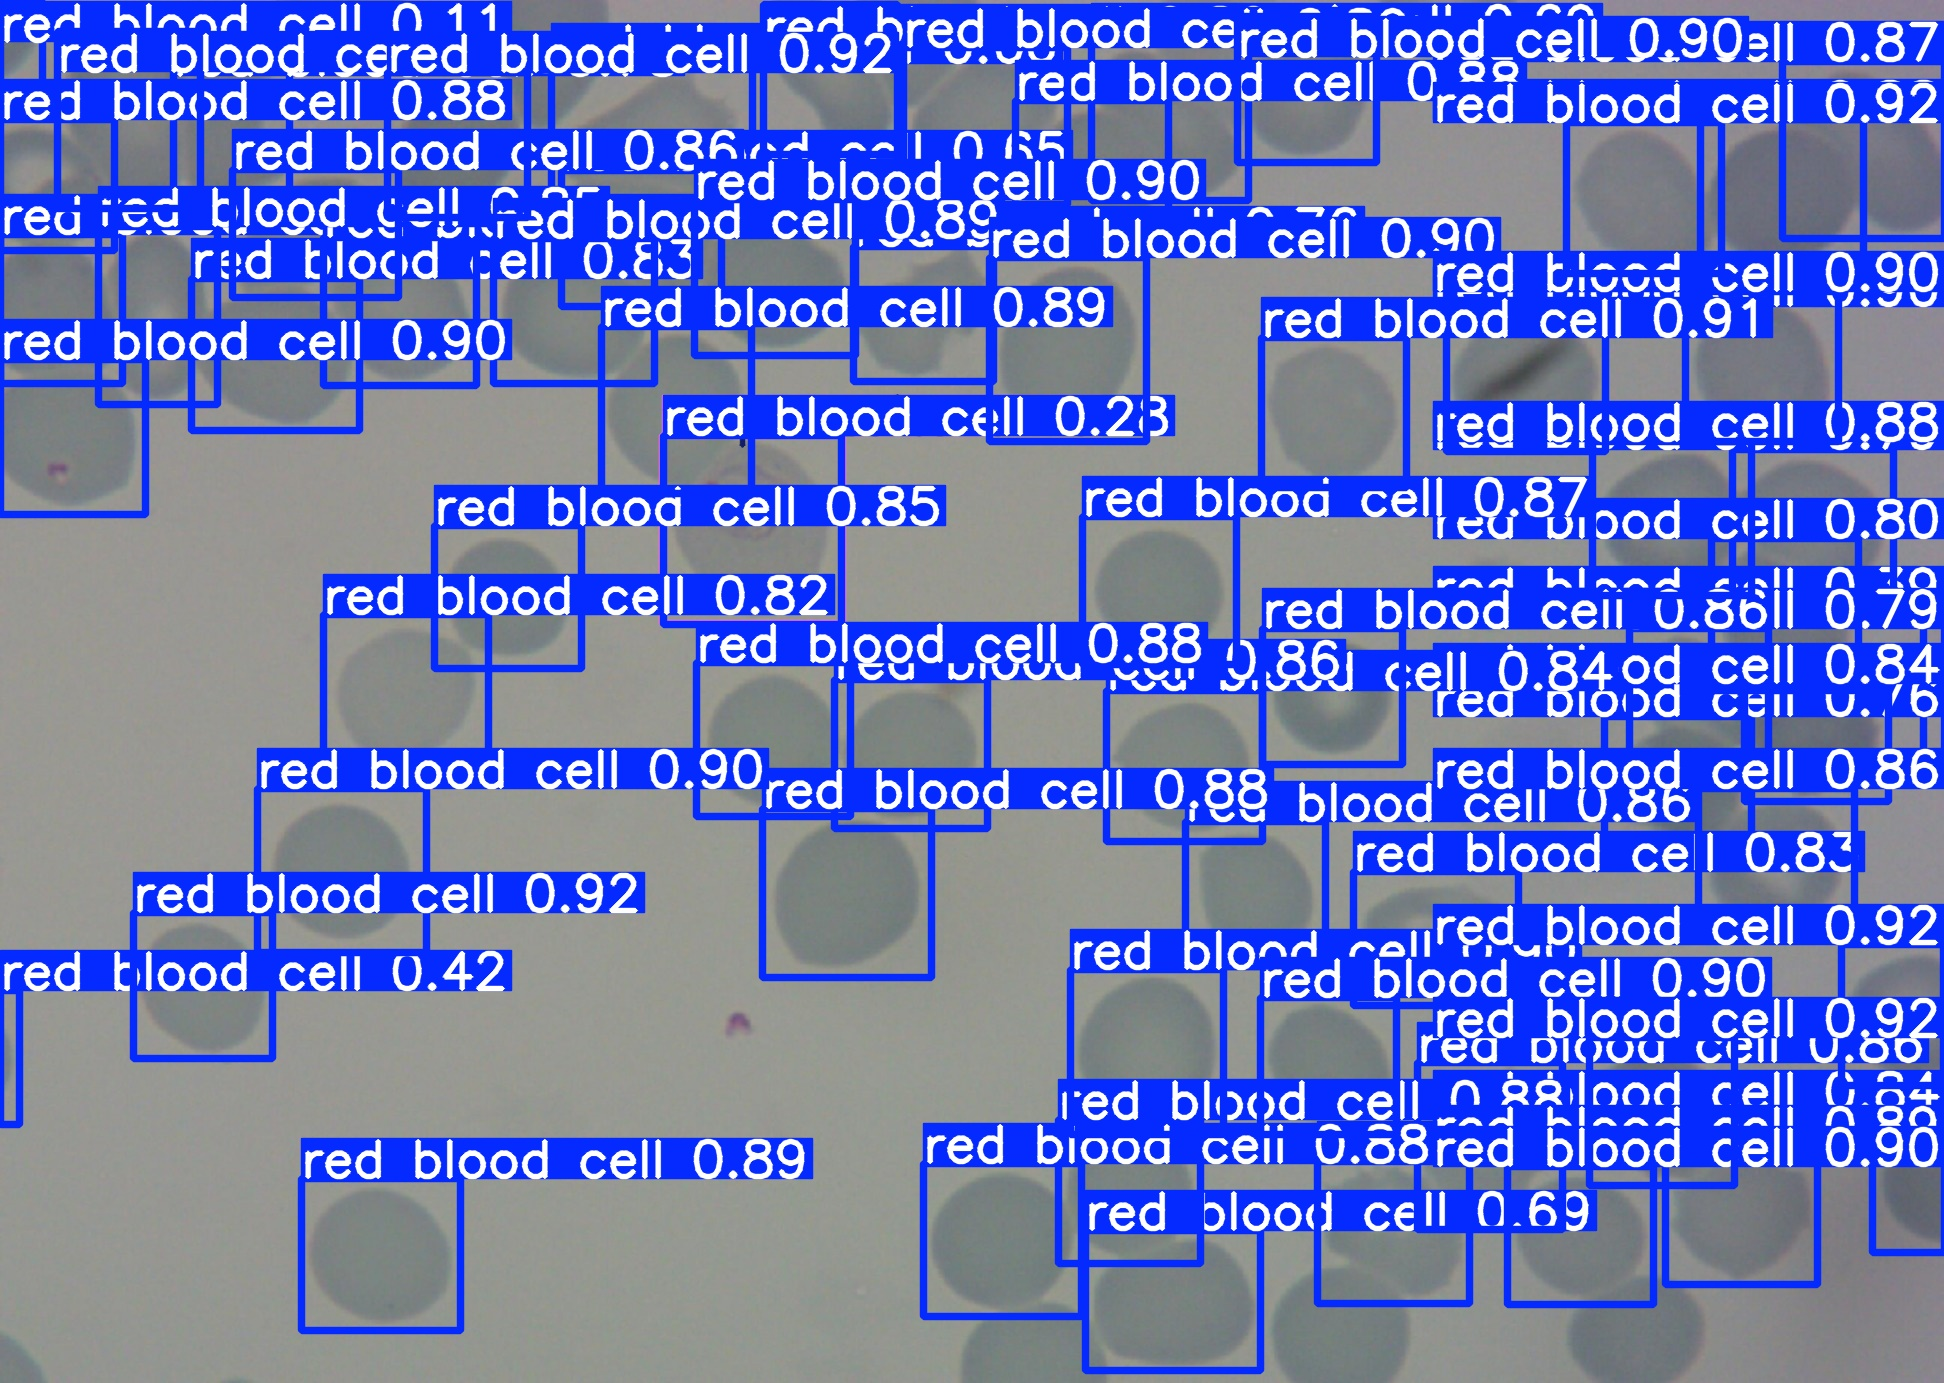

In [2]:
from ultralytics import YOLO
from IPython.display import Image, display
import os

# Ensure sample_image_path is available from the previous cell
if 'sample_image_path' not in locals() or sample_image_path is None:
    print("No sample image path found. Please run the previous cell to identify a sample image.")
else:
    weights_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'

    # Load the trained model
    model = YOLO(weights_path)

    print(f"\n--- Visualizing predictions for: {os.path.basename(sample_image_path)} ---")

    # Run inference on the sample image
    # Using conf=0.05 as identified from the interactive search for rare parasites
    results = model.predict(
        source=sample_image_path,
        imgsz=1280,
        conf=0.05, # Use a lower confidence threshold for potentially better recall of rare parasites
        iou=0.45,   # A balanced IoU threshold
        save=True,
        project='malaria_yolov8n_test_evaluation',
        name='v3_prediction_viz'
    )

    # The prediction results are saved in a 'runs/detect/name' directory
    # We need to find the path to the saved image with detections
    if results and results[0].path:
        # The `path` attribute of the result object gives the path to the original image used for prediction.
        # The output image is saved in the 'predict' folder within the project/name directory.
        # Construct the path to the predicted image.
        predicted_image_dir = os.path.join(results[0].save_dir)
        predicted_image_path = os.path.join(predicted_image_dir, os.path.basename(sample_image_path))

        if os.path.exists(predicted_image_path):
            print(f"Predictions saved to: {predicted_image_path}")
            display(Image(filename=predicted_image_path))
        else:
            print(f"Error: Predicted image not found at {predicted_image_path}")
    else:
        print("No predictions were generated or saved for the sample image.")


**Note:**

**- conf=0.05**

**- iou=0.45**  

Used for Non-Maximum Suppression (NMS) during evaluation, influencing how bounding box predictions are processed and counted as valid detections for metric calculation.

##5.5 Model Saving

In [4]:
from ultralytics import YOLO
import os

# Define the paths
best_weights_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'

# Output file name for the ONNX model
ONNX_export_path = 'best_v2.onnx'

# 1. Load the trained model
model = YOLO(best_weights_path)

# 2. Export the model to ONNX format with refined settings
print("\n--- Exporting model to ONNX with refined settings ---")
model.export(
    format='onnx',
    imgsz=1280,
    name=ONNX_export_path,
    opset=13,     # ONNX opset version. Higher opsets may support more recent features.
    simplify=True,  # Simplify the ONNX graph with onnx-simplifier
    dynamic=True    # Allow dynamic input shapes for more flexibility (e.g., variable batch size)
)

print(f"\nModel successfully exported to: {ONNX_export_path}")
print("This file will be saved in the directory where the script is executed, which is /content/")


--- Exporting model to ONNX with refined settings ---
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt' with input shape (1, 3, 1280, 1280) BCHW and output shape(s) (1, 10, 33600) (6.1 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 10 packages in 153ms
Prepared 3 packages in 2.72s
Uninstalled 1 package in 763ms
Installed 3 packages in 301ms
 + colorama==0.4.6
 - onnx==1.20.0
 + onnx==1.19.1
 + onnxslim==0.1.78

requirements: AutoUpdate success ✅ 4.3s
WARNING ⚠️ r

### 5.5.1 Make Predictions using the ONNX Model


--- Loading ONNX model from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.onnx ---
WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.

--- Visualizing ONNX predictions for: 03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg ---
Loading /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CPUExecutionProvider

image 1/1 /content/drive/MyDrive/yolov8_malaria_finetune/images/test/03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg: 928x1280 64 red blood cells, 1 trophozoite, 635.0ms
Speed: 12.8ms preprocess, 635.0ms inference, 12.3ms postprocess per image at shape (1, 3, 928, 1280)
Results saved to /content/malaria_yolov8n_test_evaluation/v3_onnx_prediction_viz2
ONNX Predictions saved to: /conte

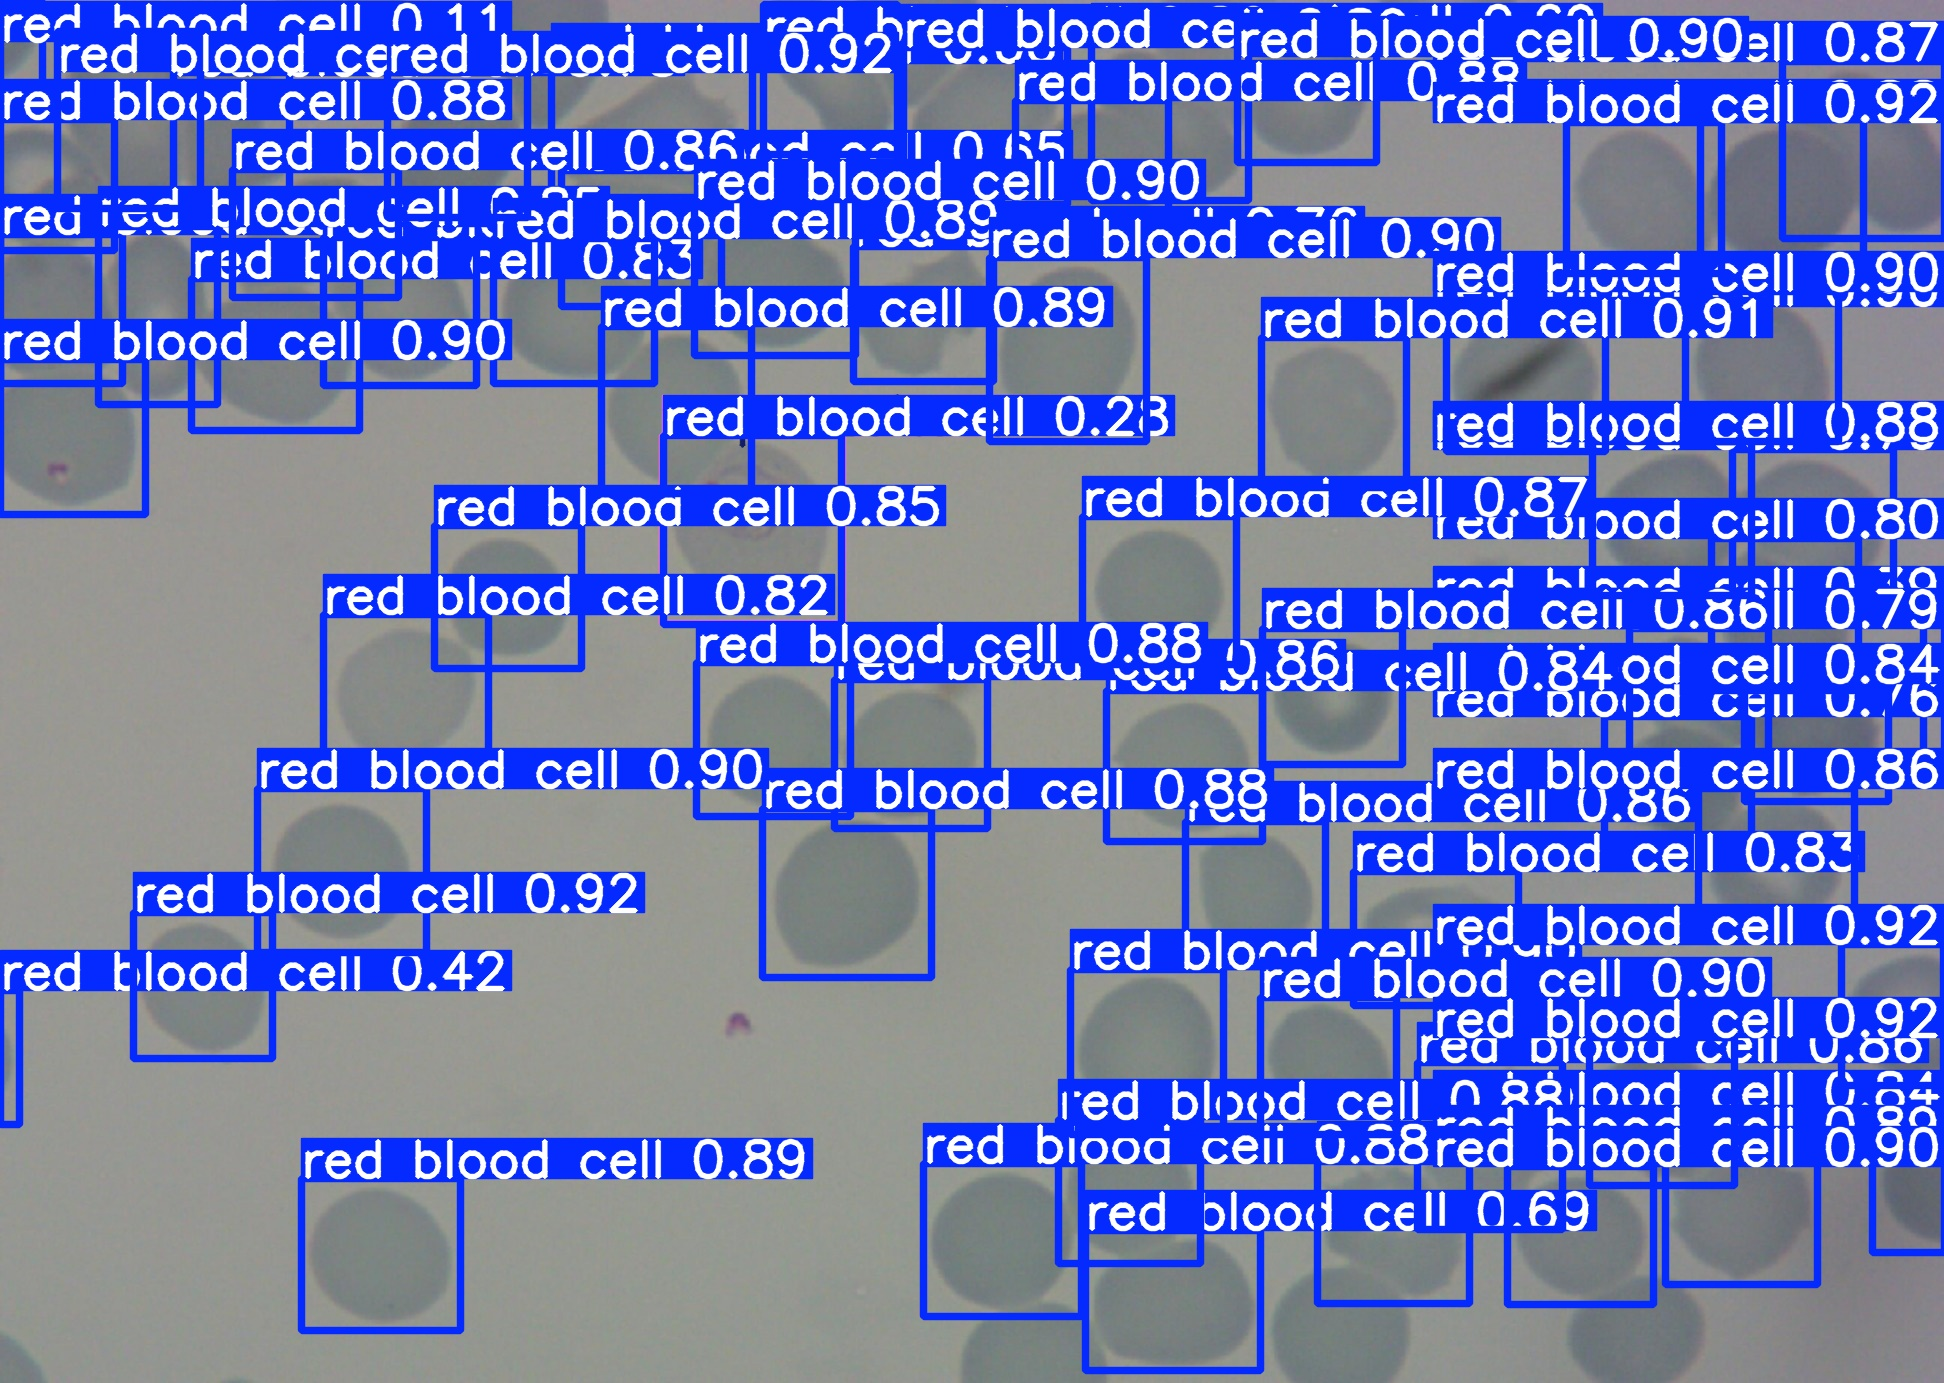

In [5]:
from ultralytics import YOLO
from IPython.display import Image, display
import os

# Path to the exported ONNX model
onnx_model_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.onnx'

# Ensure sample_image_path is available from previous cells
if 'sample_image_path' not in locals() or sample_image_path is None:
    print("No sample image path found. Please ensure the cells that identify a sample image were run.")
else:
    print(f"\n--- Loading ONNX model from: {onnx_model_path} ---")
    # Load the ONNX model
    # Note: When loading an ONNX model, you pass the path directly to YOLO()
    model_onnx = YOLO(onnx_model_path)

    print(f"\n--- Visualizing ONNX predictions for: {os.path.basename(sample_image_path)} ---")

    # Run inference on the sample image using the ONNX model
    # Using the same confidence and iou thresholds as the previous prediction
    results_onnx = model_onnx.predict(
        source=sample_image_path,
        imgsz=1280,
        conf=0.05,
        iou=0.45,
        save=True,
        project='malaria_yolov8n_test_evaluation',
        name='v3_onnx_prediction_viz'
    )

    # The prediction results are saved in a 'runs/detect/name' directory
    if results_onnx and results_onnx[0].path:
        predicted_image_dir_onnx = os.path.join(results_onnx[0].save_dir)
        predicted_image_path_onnx = os.path.join(predicted_image_dir_onnx, os.path.basename(sample_image_path))

        if os.path.exists(predicted_image_path_onnx):
            print(f"ONNX Predictions saved to: {predicted_image_path_onnx}")
            display(Image(filename=predicted_image_path_onnx))
        else:
            print(f"Error: Predicted image not found at {predicted_image_path_onnx}")
    else:
        print("No ONNX predictions were generated or saved for the sample image.")

## 5.6 Detailed Performance Analysis on Test Set using Best.pt from fine tune v2

### 5.6.1 Evaluation

In [4]:
import pandas as pd
from ultralytics import YOLO
import os
import numpy as np
import re


# --- Configuration ---
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'
weights_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune_v2_mosaic_extended/weights/best.pt'
project_name = 'ft_v2_mosaic_extended_test_eval'
run_name = 'f2_v2_test_set_results'

# --- Load Model ---
model = YOLO(weights_path)
print(f"Successfully loaded model from: {weights_path}")

# --- Run Validation (Evaluation) ---
print("\nStarting evaluation on the test set...")
metrics = model.val(
    data=DATA_YAML_PATH,
    split='test',
    imgsz=1280,
    project=project_name,
    name=run_name,
    save_json=True,
    plots=True,
    verbose=True
)

print("\n--- Evaluation Complete ---\n")

# --- Calculate Overall F1-Score ---
# Get Mean Precision (MP) and Mean Recall (MR) across all classes
mp = metrics.box.mp  # Mean Precision over all classes
mr = metrics.box.mr  # Mean Recall over all classes

# F1-Score formula: 2 * (P * R) / (P + R)
# Use np.where for stable division to prevent division by zero (NaN)
if mp is not None and mr is not None:
    denominator = mp + mr
    # F1 is 0.0 if the denominator is 0 (i.e., if both P and R are 0)
    f1_score = np.where(denominator > 0, (2 * mp * mr) / denominator, 0.0)
else:
    f1_score = 0.0

print(f"F1-Score (Overall): {f1_score:.4f}")
print("------------------------------------------")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Successfully loaded model from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune_v2_mosaic_extended/weights/best.pt

Starting evaluation on the test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.5±1.3 ms, read: 1.0±0.8 MB/s, size: 241.0 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_finetune/labels/test.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 116.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R     

In [5]:
import os

# The output directory was specified in your 'locate' instruction
results_dir = '/content/ft_v2_mosaic_extended_test_eval/f2_v2_test_set_results'

if os.path.exists(results_dir):
    print(f"Contents of '{results_dir}':")
    for item in os.listdir(results_dir):
        print(f"- {item}")
    print("\nLook for files like 'predictions.json' and various '.png' images (e.g., confusion_matrix.png, F1_curve.png, PR_curve.png, R_curve.png) for your results.")
else:
    print(f"Error: Results directory '{results_dir}' not found. Please ensure the evaluation ran successfully.")

Contents of '/content/ft_v2_mosaic_extended_test_eval/f2_v2_test_set_results':
- BoxF1_curve.png
- BoxR_curve.png
- predictions.json
- val_batch2_labels.jpg
- val_batch0_labels.jpg
- val_batch2_pred.jpg
- val_batch0_pred.jpg
- BoxPR_curve.png
- BoxP_curve.png
- confusion_matrix_normalized.png
- confusion_matrix.png
- val_batch1_pred.jpg
- val_batch1_labels.jpg

Look for files like 'predictions.json' and various '.png' images (e.g., confusion_matrix.png, F1_curve.png, PR_curve.png, R_curve.png) for your results.
